In [1]:
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

In [2]:
rutaDogsTrain = 'cat_dog_100/train/dog'
rutaDogsTest = 'cat_dog_100/test/dog'
rutaCatsTrain = 'cat_dog_100/train/cat'
rutaCatsTest = 'cat_dog_100/test/cat'

tamanoMax = 128
sizeVentana = 16
tamanoMax = int(tamanoMax/sizeVentana)*sizeVentana

In [5]:
from os import walk

dogTrain = []
dogTest = []
catTest = []
catTrain = []
for (dirpath, dirnames, filenames) in walk(rutaDogsTrain):
    dogTrain.extend(filenames)
    
for (dirpath, dirnames, filenames) in walk(rutaDogsTest):
    dogTest.extend(filenames)

for (dirpath, dirnames, filenames) in walk(rutaCatsTest):
    catTest.extend(filenames)

for (dirpath, dirnames, filenames) in walk(rutaCatsTrain):
    catTrain.extend(filenames)
    
print(f'{rutaDogsTrain}/{dogTrain[0]}')

cat_dog_100/train/dog/dog.10000.jpg


In [6]:
def filtro(imagen, mascara):
    a = mascara.shape[0]//2
    b = mascara.shape[1]//2
    imagen_ampliada = cv2.copyMakeBorder(imagen, a, a, b, b, cv2.BORDER_REPLICATE)
    imagen2 = np.zeros(imagen.shape)
    for i in range(a, imagen.shape[0] + a):
        for j in range(b, imagen.shape[1] + b):
            imagen2[i-a, j-b] = np.sum(imagen_ampliada[i-a:i+a+1, j-b:j+b+1] * mascara)
            
    return imagen2

In [7]:
def gradiente(imagen):
    m_g_x = np.array([[0, -1, 0], [0, 0, 0], [0, 1, 0]])
    m_g_y = np.array([[0, 0, 0], [-1, 0, 1], [0, 0, 0]])
    Ix = filtro(imagen, m_g_x)
    Iy = filtro(imagen, m_g_y)
    E = np.sqrt(Ix**2 + Iy**2)
    Phi = np.rad2deg(np.arctan2(Iy, Ix))
    
    return E, Phi

In [13]:
def transforma_bloque2(celdaPhi, celdaE, bins = 9):
    celdaPhi = np.abs(celdaPhi)
    hp = cv2.calcHist([np.uint8(celdaPhi)], [0], None, [bins], [0, 180])
    a = 180/bins 
    for i in range(bins):
        hp[i] += np.sum(celdaE[(celdaPhi > a*i) & (celdaPhi < -a*(i+1))])
    hp = hp / np.sqrt(np.sum(hp**2))
    return np.ravel(hp)

In [14]:
def transforma_imagen2(imagen, sizeVentana, tamanoMax):
    E, Phi = gradiente(imagen)
    Phi = resize_image(Phi, sizeVentana, tamanoMax, True)
    E = resize_image(E, sizeVentana, tamanoMax, True)
    caracteristicas = []
    a = int(Phi.shape[0]/sizeVentana)
    for i in range(a):
        for j in range(a):
            celdaPhi = Phi[i*sizeVentana:(i+1)*sizeVentana,j*sizeVentana:(j+1)*sizeVentana]
            celdaE = E[i*sizeVentana:(i+1)*sizeVentana,j*sizeVentana:(j+1)*sizeVentana]
            h = transforma_bloque2(celdaPhi, celdaE)  
            caracteristicas.append(h)
    return np.concatenate(caracteristicas)

In [15]:
def normalizar(caracteristicas, m, bins = 9):
    a = int(np.sqrt(caracteristicas.shape[0] / bins))
    caracteristicas = caracteristicas.reshape(a, a, bins)
    copia = []
    for i in range(caracteristicas.shape[0] - m//2):
        for j in range(caracteristicas.shape[1] - m//2):
            bloque = caracteristicas[i:i+m, j:j+m]
            copia.append(bloque / np.sqrt(np.sum(bloque**2)))
    return np.ravel(copia)

In [19]:
def recorta_imagen(imagen, n):
    """
    Esta función recibe una imagen y un tamaño n y recorta la imagen de tal manera que el número final de filas/columnas 
    sea múltiplo de n. La funció debe recortar las filas de la derecha/abajo.
    """
    size = np.min([int(imagen.shape[0]/n)*n, int(imagen.shape[1]/n)*n])
    return imagen[:size, :size]

def resize_image(imagen, sizeVentana, tamanoMax, recorta=False):
    if(recorta): imagen = recorta_imagen(imagen, sizeVentana)
    imagen2 = cv2.resize(imagen, [tamanoMax,tamanoMax])
    return imagen2

In [26]:
def ventana_a_decimal(ventana_binario):
    binario = np.array([ventana_binario[0,0], ventana_binario[0,1], ventana_binario[0,2], ventana_binario[1,2], ventana_binario[2,2], ventana_binario[2,1], ventana_binario[2,0], ventana_binario[1,0]])
#     anterior = binario[0]
#     cont = 0
#     for i in range(1, binario.shape[0]):
#         if binario[i] == anterior:
#             cont+=1
#         else:
#             cont = 0
#         anterior = binario[i]
#         if cont == 2:
#             binario = 0
#             break
    return np.sum(binario * np.array([128, 64, 32, 16, 8, 4, 2, 1]))

In [27]:
def transforma_bloque(celda):
    celda_ampliada = cv2.copyMakeBorder(celda, 1, 1, 1, 1, cv2.BORDER_REPLICATE)
    celda2 = np.empty(celda.shape)
    for i in range(1, celda.shape[0]+1):
        for j in range(1, celda.shape[1]+1):
            ventana = celda_ampliada[i-1:i+2, j-1:j+2]
            ventana2 = np.zeros(ventana.shape)
            pixel_central = ventana[1,1]
            ventana2[ventana>pixel_central] = 1
            celda2[i-1,j-1] = ventana_a_decimal(ventana2)
    return celda2

In [62]:
def transforma_imagen(imagen, sizeVentana, tamanoMax):
    imagen = resize_image(imagen, sizeVentana, tamanoMax, False)
    caracteristicas = []
    a = int(imagen.shape[0]/sizeVentana)
    for i in range(a):
        for j in range(a):
            celda = imagen[i*sizeVentana:(i+1)*sizeVentana,j*sizeVentana:(j+1)*sizeVentana]
            nueva_celda = transforma_bloque(celda)
            caracteristicas.append(cv2.calcHist([np.uint8(nueva_celda)], [0], None, [256], [0, 256]).ravel())
    return np.concatenate(caracteristicas)

In [63]:
n = 2
imagen = cv2.imread(f'{rutaDogsTrain}/{dogTrain[n]}',0)
caracteristicas = transforma_imagen(imagen, sizeVentana, tamanoMax)
print(caracteristicas.shape)

(16384,)


In [64]:
X = []
for i in tqdm(range(len(dogTrain)), desc = "Perros", colour = '#FF88F8'):
    imagen = cv2.imread(f'{rutaDogsTrain}/{dogTrain[i]}',0)
    caracteristicas = transforma_imagen(imagen, sizeVentana, tamanoMax)
    X.append(caracteristicas)

for i in tqdm(range(len(catTrain)), desc = "Gatos", colour = '#88FFDD'):
    imagen = cv2.imread(f'{rutaCatsTrain}/{catTrain[i]}',0)
    caracteristicas = transforma_imagen(imagen, sizeVentana, tamanoMax)
    X.append(caracteristicas)
    
X = np.array(X)
y = np.hstack((np.ones(len(dogTrain)), np.zeros(len(catTrain)))).reshape(-1, 1)


Gatos: 100%|██████████| 100/100 [00:30<00:00,  3.24it/s]


In [65]:
Xtest = []
for i in tqdm(range(len(dogTest)), desc = "Perros Test", colour = '#FF88BB'):
    imagen = cv2.imread(f'{rutaDogsTest}/{dogTest[i]}',0)
    caracteristicas = transforma_imagen(imagen, sizeVentana, tamanoMax)
    Xtest.append(caracteristicas)

for i in tqdm(range(len(catTest)), desc = "Gatos Test", colour = '#88FFE0'):
    imagen = cv2.imread(f'{rutaCatsTest}/{catTest[i]}',0)
    caracteristicas = transforma_imagen(imagen, sizeVentana, tamanoMax)
    Xtest.append(caracteristicas)
    
Xtest = np.array(Xtest)
ytest = np.hstack((np.ones(len(dogTest)), np.zeros(len(catTest)))).reshape(-1, 1)

Gatos Test: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


In [66]:
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size = 0.15, random_state = 42)
print(Xtrain.shape)

(170, 16384)


In [ ]:
X = []
m = 2
for i in tqdm(range(len(dogTrain)), desc = "Perros", colour = '#FF88F8'):
    imagen = cv2.imread(f'{rutaDogsTrain}/{dogTrain[i]}',0)
    caracteristicas = transforma_imagen2(imagen, sizeVentana, tamanoMax)
    caracteristicas = normalizar(caracteristicas, m)
    X.append(caracteristicas)

for i in tqdm(range(len(catTrain)), desc = "Gatos", colour = '#88FFDD'):
    imagen = cv2.imread(f'{rutaCatsTrain}/{catTrain[i]}',0)
    caracteristicas = transforma_imagen2(imagen, sizeVentana, tamanoMax)
    caracteristicas = normalizar(caracteristicas, m)
    X.append(caracteristicas)
    
X = np.array(X)
y = np.hstack((np.ones(len(dogTrain)), np.zeros(len(catTrain)))).reshape(-1, 1)


Gatos:  13%|█████████▌                                                                | 13/100 [00:40<04:08,  2.86s/it]

In [ ]:
Xtest = []
for i in tqdm(range(len(dogTest)), desc = "Perros Test", colour = '#FF88BB'):
    imagen = cv2.imread(f'{rutaDogsTest}/{dogTest[i]}',0)
    caracteristicas = transforma_imagen2(imagen, sizeVentana, tamanoMax)
    caracteristicas = normalizar(caracteristicas, m)
    Xtest.append(caracteristicas)

for i in tqdm(range(len(catTest)), desc = "Gatos Test", colour = '#88FFE0'):
    imagen = cv2.imread(f'{rutaCatsTest}/{catTest[i]}',0)
    caracteristicas = transforma_imagen2(imagen, sizeVentana, tamanoMax)
    caracteristicas = normalizar(caracteristicas, m)
    Xtest.append(caracteristicas)
    
Xtest = np.array(Xtest)
ytest = np.hstack((np.ones(len(dogTest)), np.zeros(len(catTest)))).reshape(-1, 1)

In [44]:
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size = 0.15, random_state = 42)

In [51]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM, TimeDistributed, GRU, SimpleRNN
import tensorflow.keras as keras

#Para ver si detecta la GPU (si no, hacer "conda install -c conda-forge cudnn" o algo así)
print(tf.config.list_physical_devices())
print("Número de GPUs disponibles: ", len(tf.config.experimental.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Número de GPUs disponibles:  1


In [82]:
model = Sequential([
    Dense(64, input_shape = (16384, )),
    Dense(1, activation = 'sigmoid')
])
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                1048640   
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,048,705
Trainable params: 1,048,705
Non-trainable params: 0
_________________________________________________________________


In [83]:
model.compile(optimizer = keras.optimizers.Adamax(), loss = keras.losses.binary_crossentropy, metrics = ['acc'])

In [84]:
historico = model.fit(
    Xtrain, 
    ytrain, 
    batch_size = 1000, 
    epochs = 32,
    validation_data= (Xval, yval)
)

Epoch 1/32
1/1 [==============================] - 1s 531ms/step - loss: 3.7953 - acc: 0.4706 - val_loss: 67.3532 - val_acc: 0.5333
Epoch 2/32
1/1 [==============================] - 0s 57ms/step - loss: 73.4803 - acc: 0.4941 - val_loss: 60.0042 - val_acc: 0.5333
Epoch 3/32
1/1 [==============================] - 0s 54ms/step - loss: 64.8750 - acc: 0.4941 - val_loss: 30.5265 - val_acc: 0.5333
Epoch 4/32
1/1 [==============================] - 0s 67ms/step - loss: 32.3482 - acc: 0.4941 - val_loss: 7.6803 - val_acc: 0.4667
Epoch 5/32
1/1 [==============================] - 0s 58ms/step - loss: 5.2472 - acc: 0.5294 - val_loss: 24.3532 - val_acc: 0.4667
Epoch 6/32
1/1 [==============================] - 0s 51ms/step - loss: 19.8448 - acc: 0.5059 - val_loss: 21.9150 - val_acc: 0.4667
Epoch 7/32
1/1 [==============================] - 0s 51ms/step - loss: 16.7452 - acc: 0.5059 - val_loss: 6.3213 - val_acc: 0.4667
Epoch 8/32
1/1 [==============================] - 0s 50ms/step - loss: 3.0874 - acc: 0

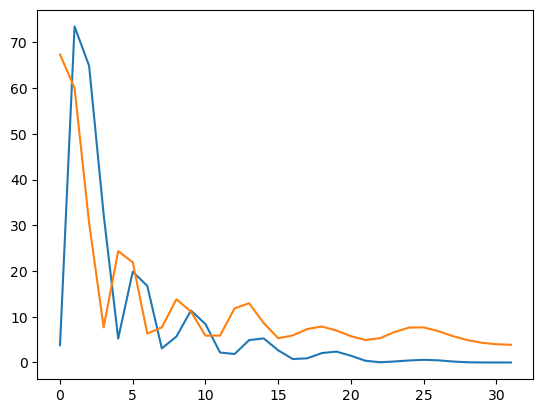

In [85]:
historial = historico.history
plt.plot(historial['loss'])
plt.plot(historial['val_loss'])

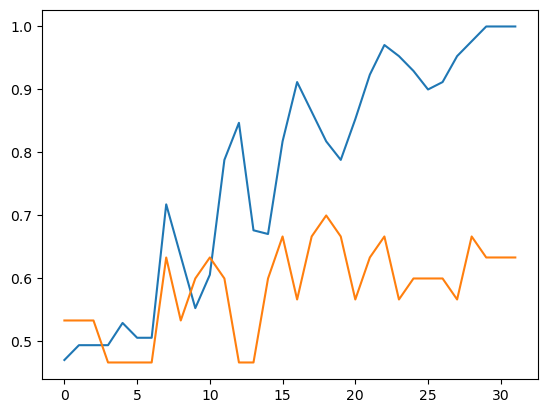

In [86]:
plt.plot(historial['acc'])
plt.plot(historial['val_acc'])

In [87]:
prediccion = model.predict(Xtest)
aciertos = np.sum(np.round(prediccion) == ytest)
print(f'{aciertos/ytest.shape[0]*100 }%')

2/2 [==============================] - 0s 3ms/step
87.5%


In [73]:
# Importamos las SVMs
from sklearn import svm
# Creamos un clasificador SVM usando svm.SVC con kernel='linear', C=1.0 y máximo número de iteraciones = 1000
svc = svm.SVC(kernel = 'linear', C = 1.0, max_iter = 10000)
svc

SVC(kernel='linear', max_iter=10000)

In [74]:
# Entrenamos el modelo
svc.fit(X, y.ravel())
# Obtenemos la precisión
accTrain = svc.score(X, y)
print("Precisión en train: {}%".format(accTrain*100))

Precisión en train: 100.0%


In [75]:
print(svc.score(Xtest, ytest))

0.875
